In [144]:
%pip install pandas numpy matplotlib seaborn scipy


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [145]:
#### Import all the needed packages
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from scipy.stats import norm
from statsmodels.stats.outliers_influence import (OLSInfluence,
                                                  variance_inflation_factor)
from statsmodels.tools.tools import add_constant

In [146]:
def get_parameter_values(S0, K, T, r, q, sigma): 
    # d1 and d2 
    d1 = (np.log(S0/K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
       
    # Lambda value 
    lambda_ = (r - q + 0.5 * sigma**2) / sigma**2
    
    # Vanilla call value
    c = S0 * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2) 
    
    return lambda_, c

 
def down_and_call_book(S0, K, T, r, q, sigma,H, H_down, H_up):
    
    # Values for the different functions 
    lambda_, c = get_parameter_values(S0, K, T, r, q, sigma)
    
    # Value for the down and out
    y = np.log(H_down**2 / (S0*K)) / (sigma * np.sqrt(T)) + lambda_ * sigma * np.sqrt(T)
    
    # Values for the down and in 
    x1 = np.log(S0/H_up) / (sigma * np.sqrt(T)) + lambda_ * sigma * np.sqrt(T)
    y1 = np.log(H_up/S0) / (sigma * np.sqrt(T)) + lambda_ * sigma * np.sqrt(T)

    # Calculate option values for call
    if H <= K:
        #Down and out
        cdi = S0 * np.exp(-q * T) * (H_down/S0)**(2*lambda_) * norm.cdf(y) - K * np.exp(-r * T) * (H_down/S0)**(2*lambda_ - 2) * norm.cdf(y - sigma * np.sqrt(T))
        cdo = c  - cdi
        return cdo
    else:
        #Down and in
        cdo = S0 * np.exp(-q * T) * norm.cdf(x1) - K * np.exp(-r * T) * norm.cdf(x1 - sigma * np.sqrt(T)) 
        - S0 * np.exp(-q * T) * (H_up/S0)**(2*lambda_) * norm.cdf(y1) + K * np.exp(-r * T) * (H_up/S0)**(2*lambda_ - 2) * norm.cdf(y1 - sigma * np.sqrt(T))
        cdi = c - cdo
        
        return cdi


In [147]:
### Function for finding strictly increase but with the H_log version instead
def is_decreasing(arr):
    return all(arr[i] <= arr[i + 1] for i in range(len(arr) - 1))

def find_strictly_decrease(data, T_val, sigma_val):
    filtered_data = data[(data['sigma'] == sigma_val) & (data['T'] == T_val)]
    sorted_data = filtered_data.sort_values(by='H_log', ascending=False)
    
    if filtered_data.empty:
        return 0
    
    for i in range(len(sorted_data)):
        split_array = sorted_data.iloc[i:]
        mapped_numbers = split_array['error_percent'].astype(float).tolist()
        if is_decreasing(mapped_numbers):
            return sorted_data.iloc[i]['H_log']
            
    return 0

In [148]:
########## Adjust the barriers
def regression_beta(T, sigma, H, S0, data):
    H_log = abs(np.log(H/S0))
    prod = sigma*np.sqrt(T)
    
    ### Todo find a generalised function for this 
    h_increase = -0.0645*prod**2 + 0.1702*prod + 0.0041
    beta = 0.5826
    
    # From regresion_exp function
    if  H_log <= h_increase:
        beta = 0.6467 * np.exp(-1.7046 * H_log + 0.1026 * prod)

    return beta

# Function to adjust the barrier for discrete monitoring
def adjusted_barrier_custom(T, H, S0,K, sigma, m, beta, data):
    
    # dT should be here, it "is the time between monitoring instants", p.325, also stated in book from michael at p.628
    delta_T = T / m
    beta = regression_beta(T, sigma, H, S0, data)

    ### adjust the beta value
    H_adj_down = H * np.exp(-1 * beta * sigma * np.sqrt(delta_T))
    H_adj_up = H * np.exp(beta * sigma * np.sqrt(delta_T))

    return H_adj_down, H_adj_up

In [149]:
# Load the CSV file
df_combined = pd.read_csv('data.csv')

# Adjust the dataset based on your criteria
# For simplicity, using the whole dataset as is, assuming necessary columns exist
df_combined['Sigma_sqrt_T'] = df_combined['sigma'] * np.sqrt(df_combined['T'])

# Define the exponential model for curve fitting
def exponential_model(X, a, b1, b2):
    H_log, sigma_sqrt_t = X
    return a * np.exp(b1 * H_log + b2 * sigma_sqrt_t)

# Prepare the data for fitting
X = (df_combined['H_log'].values, df_combined['Sigma_sqrt_T'].values)
y = df_combined['best_beta'].values

# Fit the exponential model
params, covariance = curve_fit(exponential_model, X, y)

# Extract the parameters
a, b1, b2 = params

# Linear model for Cook's distance - using OLS for simplicity
# Prepare data for OLS: here, we choose 'H_log' and 'Sigma_sqrt_T' as predictors
X_ols = df_combined[['H_log', 'Sigma_sqrt_T']]
y_ols = df_combined['best_beta']

# Add a constant to the predictors
X_ols = sm.add_constant(X_ols)

# Fit OLS model
model_ols = sm.OLS(y_ols, X_ols).fit()

# Calculate Cook's distance
influence = model_ols.get_influence()
cooks_d = influence.cooks_distance[0]

# Plot Cook's distance
"""
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", use_line_collection=True)
plt.title("Cook's Distance")
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.show()
"""

# Identify points with high Cook's distance
high_cooks_d_indices = np.where(cooks_d > 4 / len(X_ols))[0]
print("Indices with high Cook's distance:", high_cooks_d_indices)

# Optional: Remove these points and refit the model if necessary
# Step 1: Remove influential points
df_filtered = df_combined.drop(high_cooks_d_indices).reset_index(drop=True)

# Prepare the data for fitting again, this time with the filtered dataset
X_filtered = (df_filtered['H_log'].values, df_filtered['Sigma_sqrt_T'].values)
y_filtered = df_filtered['best_beta'].values

# Step 2: Refit the exponential model with the filtered data
params_filtered, covariance_filtered = curve_fit(exponential_model, X_filtered, y_filtered)

# Extract the parameters for the new model
a_filtered, b1_filtered, b2_filtered = params_filtered

# Print the equation of the fitted exponential model
print(f"Fitted exponential equation: Beta = {a:.4f} * exp({b1:.4f} * H_log + {b2:.4f} * sigma_sqrt_T)")

# Predict values using the new model parameters
y_pred_filtered = exponential_model(X_filtered, a_filtered, b1_filtered, b2_filtered)

# Step 3: Evaluate the new model
# Since R² is not directly provided by curve_fit, we calculate it manually
ss_res_filtered = np.sum((y_filtered - y_pred_filtered) ** 2)
ss_tot_filtered = np.sum((y_filtered - np.mean(y_filtered)) ** 2)
r_squared_filtered = 1 - (ss_res_filtered / ss_tot_filtered)

print(f"Filtered Model R² value: {round(r_squared_filtered, 2)}")

Indices with high Cook's distance: [   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   18   19   20   21   22   27   28   29   30   36   37   38
   39   45   46   47   54   55   56   63   64   72   73   81   82   90
   91   99  108  117  126  135  144  153  441  442  450  459  460  477
  504 1277 1286 1295 1304 1313 1322 1655 1664 1673 1682 1691 1700 1709
 1718 1726 1727 1735 1736 1744 1745 1753 1754 1762 1763 2051 2060 2104
 2113 2122 2175 2184 2193 2202 3528 3529 3530 3531 3532 3537 3538 3539
 3546 3547 3556 3564 3573 3969 3970 3971 3972 3973 3974 3975 3976 3977
 3978 3979 3980 3981 3982 3983 3984 3987 3988 3989 3990 3991 3996 3997
 3998 3999 4000 4005 4006 4007 4008 4014 4015 4016 4023 4024 4025 4032
 4033 4041 4042 4050 4051 4059 4060 4068 4077 4086 4095 4104 4113 4122
 4131]
Fitted exponential equation: Beta = 0.6467 * exp(-1.7046 * H_log + 0.1026 * sigma_sqrt_T)
Filtered Model R² value: 0.76


Maximum Error - Original Method: 14.4161%
Maximum Error - Custom Method: 1.3716%


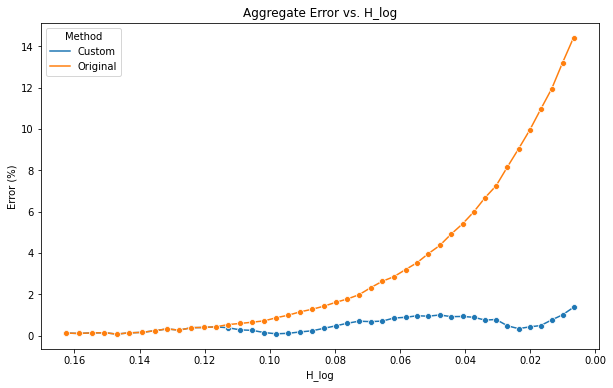

In [150]:

def plot_aggregated_errors(csv_file_path):
    # Step 1: Load the data
    df = pd.read_csv(csv_file_path)
    
    # Initialize a list to store error calculations
    errors = []

    for index, row in df.iterrows():
        q = 0
        r= 0.1 
        beta = 0.5826
        m = 50
        
        # Extract necessary values from the row
        T, H, S0, K, sigma, H_percent = row['T'], row['H'], row['S0'], row['K'], row['sigma'], row['H_log']
        
        # Calculate for custom and regular barriers
        H_down, H_up = adjusted_barrier_custom(T, H, S0, K, sigma, m, beta, df)
        
        price_original = row['price_adj']
        price_custom = down_and_call_book(S0, K, T, r, q, sigma, H, H_down, H_up)
        
        price_mc = row['price_iter']
        error_original = round(abs(((price_mc - price_original) / price_mc) * 100), 4)
        error_custom = round(abs(((price_mc - price_custom) / price_mc) * 100), 4)
            
        errors.append({'H_log': H_percent, 'Error': error_original, 'Type': 'Original'})
        errors.append({'H_log': H_percent, 'Error': error_custom, 'Type': 'Custom'})
        
        #print("Price ",  price_custom, "Price_iter ", price_mc,   "H ", H, "Sigma ", sigma,  "T ", T  )
        
    # Convert errors list to DataFrame for plotting
    df_errors = pd.DataFrame(errors)

    # Aggregate errors by H_percent and Type
    df_agg = df_errors.groupby(['H_log', 'Type'], as_index=False)['Error'].mean()

    # Find the maximum error values for each method
    max_error_original = df_agg[df_agg['Type'] == 'Original']['Error'].max()
    max_error_custom = df_agg[df_agg['Type'] == 'Custom']['Error'].max()

    print(f"Maximum Error - Original Method: {max_error_original:.4f}%")
    print(f"Maximum Error - Custom Method: {max_error_custom:.4f}%")
    
    # Step 3: Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_agg, x='H_log', y='Error', hue='Type', marker='o')
    plt.title('Aggregate Error vs. H_log')
    plt.xlabel('H_log')
    plt.ylabel('Error (%)')
    plt.legend(title='Method')
    plt.gca().invert_xaxis()  # Invert the x-axis to have the largest H_percent start on the left
    plt.show()

# Assuming 'paper_values.csv' is your data file
plot_aggregated_errors('paper_values_300.csv')
